In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
%matplotlib inline

In [500]:
#First step - data processing & features engineering. Check data and build metrics

In [501]:
#dataframe with all actions with course
events_data = pd.read_csv("event_data_train.csv")
events_data

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [502]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [503]:
#making the column with date of actions
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35
...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30


In [504]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [505]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [506]:
#making the specific column with day 
events_data['day'] = events_data.date.dt.date
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


<Axes: xlabel='day'>

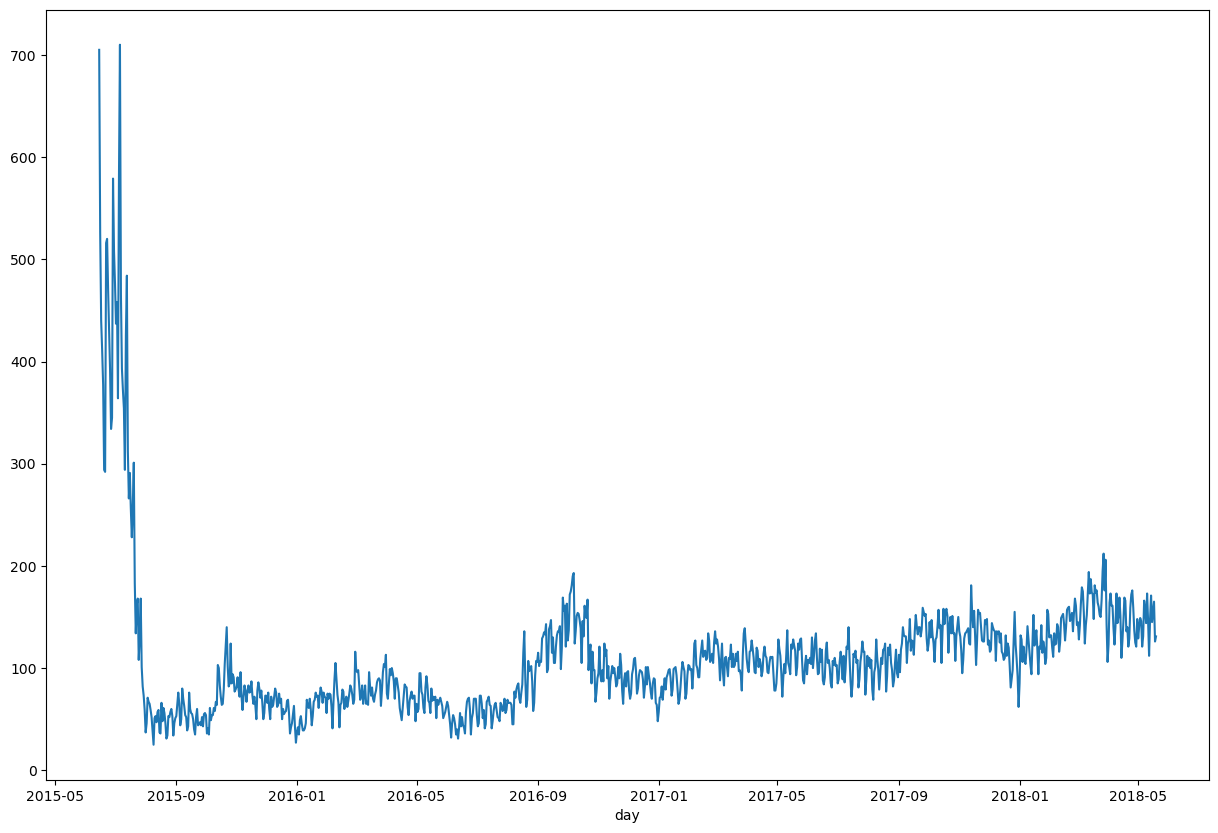

In [507]:
#plot with activity of users in time
events_data.groupby('day').user_id.nunique().plot(figsize=(15,10))

In [508]:
#the quantity of passed steps of each user
events_data[events_data.action == 'passed'] \
   .groupby('user_id', as_index=False) \
   .agg({'step_id': 'count'}) \
   .rename(columns={'step_id':'passed_steps'})

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84
...,...,...
17257,26789,2
17258,26790,8
17259,26794,69
17260,26797,10


<Axes: >

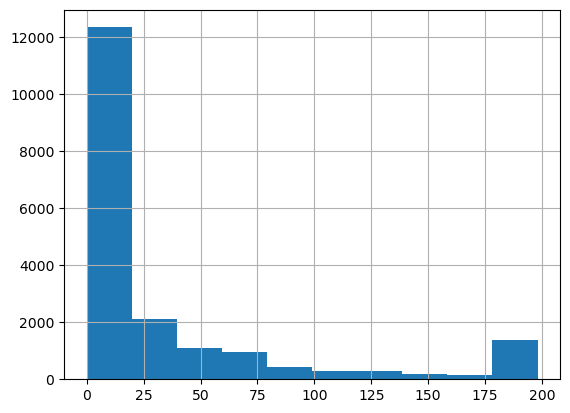

In [509]:
#making another dataframe with data of activity of each user
users_events_data = events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0) \
   .reset_index()
users_events_data.passed.hist()

In [510]:
users_events_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [511]:
#deciding with threshold should be used as "user_is_gone" threshold
gap_data = events_data[['user_id', 'day','timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [512]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [513]:
gap_data = gap_data / (24 * 60 * 60)

<Axes: >

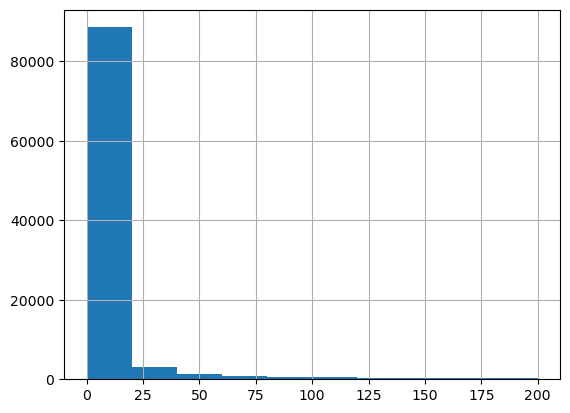

In [514]:
#quantity of days users have spent on course
gap_data[gap_data < 200].hist()

In [515]:
gap_data.quantile(0.95)

59.760440972222156

In [516]:
gap_data.quantile(0.90)

18.325995370370403

In [517]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


In [518]:
#looking how many steps there were on the course
#passed_steps = events_data.query("action == 'passed'").groupby('user_id').agg({'step_id': 'count'})

In [519]:
#passed_steps.sort_values('step_id', ascending=False)

In [520]:
#passed_steps = passed_steps.query('step_id == 198')
#passed_steps

In [521]:
events_data.step_id.max()

158433

In [522]:
last_step = events_data.query('step_id == 158433').groupby('user_id').head()
last_step

,step_id,timestamp,action,user_id,date,day
1780990,158433,1485263664,passed,1046,2017-01-24 13:14:24,2017-01-24
1780991,158433,1485263664,viewed,1046,2017-01-24 13:14:24,2017-01-24
1780992,158433,1485263664,discovered,1046,2017-01-24 13:14:24,2017-01-24
1781275,158433,1485271669,passed,3931,2017-01-24 15:27:49,2017-01-24
1781276,158433,1485271669,discovered,3931,2017-01-24 15:27:49,2017-01-24
...,...,...,...,...,...,...
3479620,158433,1526755659,passed,2058,2018-05-19 18:47:39,2018-05-19
3479621,158433,1526755659,viewed,2058,2018-05-19 18:47:39,2018-05-19
3479953,158433,1526759298,passed,19410,2018-05-19 19:48:18,2018-05-19
3479954,158433,1526759298,discovered,19410,2018-05-19 19:48:18,2018-05-19


In [523]:
last_step.query("action == 'passed'").sort_values('date')

,step_id,timestamp,action,user_id,date,day
1780990,158433,1485263664,passed,1046,2017-01-24 13:14:24,2017-01-24
1781275,158433,1485271669,passed,3931,2017-01-24 15:27:49,2017-01-24
1781402,158433,1485276014,passed,14985,2017-01-24 16:40:14,2017-01-24
1782093,158433,1485288441,passed,10626,2017-01-24 20:07:21,2017-01-24
1782261,158433,1485292242,passed,3876,2017-01-24 21:10:42,2017-01-24
...,...,...,...,...,...,...
3478762,158433,1526744472,passed,19147,2018-05-19 15:41:12,2018-05-19
3479191,158433,1526750524,passed,13751,2018-05-19 17:22:04,2018-05-19
3479506,158433,1526754540,passed,19491,2018-05-19 18:29:00,2018-05-19
3479620,158433,1526755659,passed,2058,2018-05-19 18:47:39,2018-05-19


In [524]:
last_step = events_data.query('step_id == 158433').groupby('user_id')

In [525]:
#looking fot last timestamp for each user
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp' : 'max'}).rename(columns={'timestamp' : 'last_timestamp'})
users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [526]:
now = events_data.timestamp.max()

In [527]:
max_timestamp = 30 * 24 * 60 * 60

In [528]:
#if the person haven't done anyting with the course last 30 days, we would think he is gone and won't complete the course
users_data['is_gone'] = (now - users_data.last_timestamp) > max_timestamp
users_data

,user_id,last_timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [529]:
#uploading data with all submissions
submission_data = pd.read_csv('submissions_data_train.csv')

In [530]:
submission_data

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [531]:
#making the column with date of each submission, then making the column with days
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit='s')
submission_data

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03
...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56


In [532]:
submission_data['day'] = submission_data.date.dt.date
submission_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [533]:
#calculating the quantity of correct and incorrect submissions for each user
scores = submission_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0) \
   .reset_index()
scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [534]:
users_data = users_data.merge(scores, on='user_id',how='outer')

In [535]:
#filling the gaps
users_data.fillna(0)

,user_id,last_timestamp,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


In [536]:
#merging all data
users_data = users_data.merge(users_events_data, how='outer')
users_data

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,NaN,NaN,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,NaN,NaN,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,NaN,NaN,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


In [537]:
users_days = events_data.groupby('user_id').day.nunique()
users_days = users_days.to_frame().reset_index()

In [538]:
users_data = users_data.merge(users_days, how='outer')
users_data

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,NaN,NaN,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,NaN,NaN,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,NaN,NaN,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


In [539]:
users_data.user_id.nunique() 

19234

In [540]:
events_data.user_id.nunique()

19234

In [541]:
users_data['passed_course'] = users_data.passed > 170

In [542]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,8515,8515,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


<Axes: >

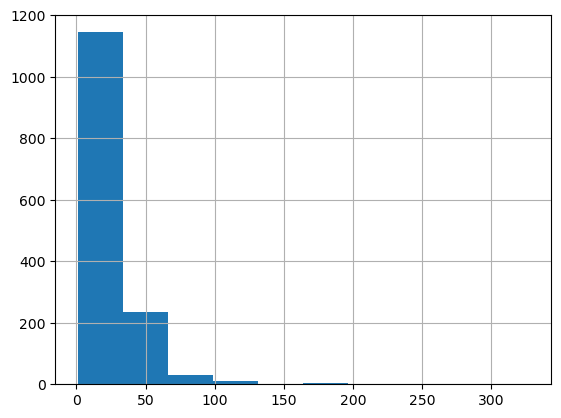

In [543]:
users_data[users_data.passed_course].day.hist()

In [544]:
#calculating the time of first action for each user
user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp' : 'min'}) \
    .rename({'timestamp' : 'min_timestamp'}, axis=1)
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [545]:
users_data = users_data.merge(user_min_time, how='outer')
users_data

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,NaN,NaN,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,NaN,NaN,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,NaN,NaN,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [546]:
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


In [547]:
#adding a column with min_timestamp
another = events_data.merge(users_data[['min_timestamp', 'user_id']],
                                                  on='user_id', how='left')
another

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19,1511358209
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [548]:
events_train_data = another.query("timestamp <= min_timestamp + 3 * 24 * 60 * 60")
events_train_data

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480530,32953,1526766998,viewed,24555,2018-05-19 21:56:38,2018-05-19,1526729867
3480531,32953,1526766998,discovered,24555,2018-05-19 21:56:38,2018-05-19,1526729867
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [549]:
users_data

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,NaN,NaN,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,NaN,NaN,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,NaN,NaN,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [550]:
events_data = events_data.merge(users_data[['last_timestamp', 'user_id', 'is_gone']],
                                                  on='user_id', how='left')
events_data

,step_id,timestamp,action,user_id,date,day,last_timestamp,is_gone
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1505649546,True
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1505649546,True
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1505649546,True
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1505649546,True
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1505649546,True
...,...,...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19,1526772685,False
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False


In [551]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [552]:
last_steps = events_data.query("timestamp == last_timestamp & action == 'started_attempt' & is_gone == True")
last_steps

,step_id,timestamp,action,user_id,date,day,last_timestamp,is_gone
1899,32812,1434348177,started_attempt,11267,2015-06-15 06:02:57,2015-06-15,1434348177,True
9753,32812,1434362581,started_attempt,1879,2015-06-15 10:03:01,2015-06-15,1434362581,True
15539,32812,1434371601,started_attempt,10115,2015-06-15 12:33:21,2015-06-15,1434371601,True
21395,32219,1434379340,started_attempt,6959,2015-06-15 14:42:20,2015-06-15,1434379340,True
21555,32219,1434379540,started_attempt,8587,2015-06-15 14:45:40,2015-06-15,1434379540,True
...,...,...,...,...,...,...,...,...
3358164,32219,1524136800,started_attempt,13181,2018-04-19 11:20:00,2018-04-19,1524136800,True
3358165,31971,1524136800,started_attempt,13181,2018-04-19 11:20:00,2018-04-19,1524136800,True
3358166,31978,1524136800,started_attempt,13181,2018-04-19 11:20:00,2018-04-19,1524136800,True
3358167,31972,1524136800,started_attempt,13181,2018-04-19 11:20:00,2018-04-19,1524136800,True


In [553]:
last_steps.groupby("step_id", as_index=False).agg({'step_id': 'count'}).sort_values('step_id', ascending=False)

,step_id
75,91
21,80
28,66
4,64
19,58
...,...
64,1
66,1
37,1
32,1


In [554]:
submission_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


In [555]:
#calculating the time of last action for each user
users_max_time = submission_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'})
users_max_time

,user_id,last_timestamp
0,2,1514383485
1,3,1444573728
2,5,1499859730
3,8,1480604143
4,14,1436368601
...,...,...
9935,26787,1469015051
9936,26790,1451722691
9937,26794,1511374868
9938,26797,1508425828


In [556]:
#merging data in submission_data dataframe
submission_data = submission_data.merge(users_data[['user_id', 'passed_course']],
                                                  on='user_id', how='left')
submission_data

,step_id,timestamp,submission_status,user_id,date,day,passed_course
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,True
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,True
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,True
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,True
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,True
...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,False
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,False
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,False
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,False


In [557]:
submission_data = submission_data.merge(users_max_time,
                                                  on='user_id', how='left')
submission_data

,step_id,timestamp,submission_status,user_id,date,day,passed_course,last_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,True,1479734163
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,True,1479734163
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,True,1479734163
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,True,1479734163
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,True,1479734163
...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,False,1501946959
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,False,1503059927
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,False,1506348153
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,False,1523035316


In [558]:
#looking fot insights like the hardest step (people have tryed it and haven't complete the course)
last_steps = submission_data.query("passed_course == False & submission_status == 'wrong' & timestamp == last_timestamp")
last_steps

,step_id,timestamp,submission_status,user_id,date,day,passed_course,last_timestamp
1696,33025,1436094981,wrong,18175,2015-07-05 11:16:21,2015-07-05,False,1436094981
5588,32173,1435303058,wrong,6053,2015-06-26 07:17:38,2015-06-26,False,1435303058
6184,33350,1490785375,wrong,19739,2017-03-29 11:02:55,2017-03-29,False,1490785375
7332,32202,1492184437,wrong,17578,2017-04-14 15:40:37,2017-04-14,False,1492184437
7699,33481,1460305649,wrong,21164,2016-04-10 16:27:29,2016-04-10,False,1460305649
...,...,...,...,...,...,...,...,...
509088,120745,1490136174,wrong,5608,2017-03-21 22:42:54,2017-03-21,False,1490136174
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,False,1501946959
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,False,1506348153
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,False,1523035316


In [559]:
last_steps.groupby('step_id', as_index=False).agg({'user_id' : 'count'}).sort_values('user_id', ascending=False)

,step_id,user_id
4,31978,154
28,32812,132
11,32031,97
19,32202,87
42,33481,77
...,...,...
51,33669,1
43,33482,1
9,31988,1
69,33998,1


In [560]:
#check if data is in correct time threshold
events_train_data.groupby('user_id').day.nunique().max()

4

In [561]:
events_train_data

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480530,32953,1526766998,viewed,24555,2018-05-19 21:56:38,2018-05-19,1526729867
3480531,32953,1526766998,discovered,24555,2018-05-19 21:56:38,2018-05-19,1526729867
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750


In [562]:
#merging the passed course column with events_train_data
events_train_data = events_train_data.merge(users_data[['passed_course', 'user_id']], on='user_id',how='left')
events_train_data

,step_id,timestamp,action,user_id,date,day,min_timestamp,passed_course
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,False
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848,False
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848,False
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848,False
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848,False
...,...,...,...,...,...,...,...,...
1014980,32953,1526766998,viewed,24555,2018-05-19 21:56:38,2018-05-19,1526729867,False
1014981,32953,1526766998,discovered,24555,2018-05-19 21:56:38,2018-05-19,1526729867,False
1014982,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False
1014983,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False


In [563]:
#saving in pandas series a "y-column", which should be predicted
passed_course = events_train_data['passed_course']
events_train_data = events_train_data.drop('passed_course', axis=1)

In [564]:
events_train_data.groupby('user_id').day.nunique().max()

4

In [565]:
submission_data

,step_id,timestamp,submission_status,user_id,date,day,passed_course,last_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,True,1479734163
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,True,1479734163
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,True,1479734163
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,True,1479734163
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,True,1479734163
...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,False,1501946959
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,False,1503059927
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,False,1506348153
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,False,1523035316


In [566]:
submission_data = submission_data.merge(user_min_time, on='user_id', how='left')
submission_data

,step_id,timestamp,submission_status,user_id,date,day,passed_course,last_timestamp,min_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,True,1479734163,1434345977
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,True,1479734163,1434345977
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,True,1479734163,1434345977
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,True,1479734163,1434345977
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,True,1479734163,1434345977
...,...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,False,1501946959,1501946660
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,False,1503059927,1503055287
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,False,1506348153,1506347263
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,False,1523035316,1523035269


In [567]:
events_data

,step_id,timestamp,action,user_id,date,day,last_timestamp,is_gone
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1505649546,True
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1505649546,True
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1505649546,True
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1505649546,True
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1505649546,True
...,...,...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19,1526772685,False
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19,1526772750,False


In [568]:
#using for training submussuin_data only for 3 days
submission_train_data = submission_data.query('timestamp - min_timestamp <= 3 * 24 * 60 * 60')
submission_train_data

,step_id,timestamp,submission_status,user_id,date,day,passed_course,last_timestamp,min_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,True,1479734163,1434345977
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,True,1479734163,1434345977
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,True,1479734163,1434345977
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,True,1479734163,1434345977
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,True,1479734163,1434345977
...,...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,False,1501946959,1501946660
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,False,1503059927,1503055287
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,False,1506348153,1506347263
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,False,1523035316,1523035269


### creating a train dataset

In [569]:
X = submission_train_data.groupby('user_id').day.nunique().to_frame().reset_index()
X.head()

,user_id,day
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [570]:
steps_tried = submission_train_data.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns = {'step_id' : 'steps_tried'})
steps_tried

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23
...,...,...
8908,26787,3
8909,26790,1
8910,26794,27
8911,26797,2


In [571]:
X = X.merge(steps_tried, on='user_id', how='outer')
X.head()

,user_id,day,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [572]:
X = X.merge(submission_train_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0) \
   .reset_index())
X

,user_id,day,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [573]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X

,user_id,day,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


In [574]:
X = X.merge(events_train_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0) \
   .reset_index()[['user_id', 'viewed']], how='outer')

In [575]:
X

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,NaN,NaN,NaN,NaN,NaN,1
19230,26781,NaN,NaN,NaN,NaN,NaN,6
19231,26788,NaN,NaN,NaN,NaN,NaN,1
19232,26789,NaN,NaN,NaN,NaN,NaN,2


In [576]:
X = X.fillna(0)
X

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


In [577]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone']], how='outer')
X

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [578]:
X = X[~((X.is_gone == False) & (X.passed_course == False))]
X
#We need a dataframe without users who are still working on the course, 
#now we only have a data of people who either passed the course or have gone
#and wouldn't pass it 

,user_id,day,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [579]:
X.groupby(['passed_course', 'is_gone']).user_id.count()

passed_course  is_gone
False          True       16560
True           False        141
               True        1284
Name: user_id, dtype: int64

In [580]:
y = X.passed_course.map(int)
X = X.drop(['passed_course', 'is_gone'], axis=1)

In [581]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


In [582]:
y

0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_course, Length: 17985, dtype: int64

In [583]:
#First explore the logistic regression model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [584]:
clf = LogisticRegressionCV(max_iter=10000)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(x_train, y_train)

LogisticRegressionCV(max_iter=10000)

In [585]:
clf.score(x_test, y_test)

0.930256064690027

In [586]:
cross_val_score(clf, x_train, y_train, cv=4).mean()

0.9184169396096331

In [587]:
y_pred = clf.predict(x_test)

In [588]:
precision = precision_score(y_test, y_pred)
precision

0.5317460317460317

In [589]:
recall = recall_score(y_test, y_pred)
recall

0.15876777251184834

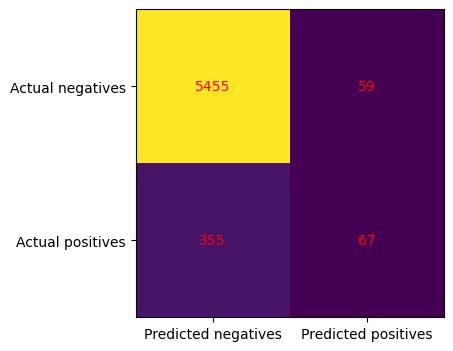

In [590]:
cm = confusion_matrix(y_test, clf.predict(x_test))

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted negatives', 'Predicted positives'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual negatives', 'Actual positives'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [591]:
predicted_prob = clf.predict_proba(x_test)
predicted_prob

array([[0.93187949, 0.06812051],
       [0.97391346, 0.02608654],
       [0.93618337, 0.06381663],
       ...,
       [0.97377557, 0.02622443],
       [0.83818772, 0.16181228],
       [0.97387216, 0.02612784]])

Best Threshold=0.084653, G-Mean=0.778


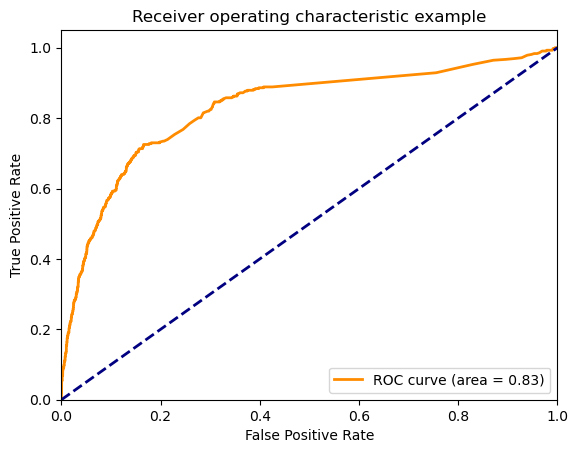

array([1.97347014, 0.97347014, 0.9489743 , 0.91046507, 0.87945194,
       0.87897119, 0.86311343, 0.84688869, 0.77782347, 0.75315094,
       0.75266358, 0.73749846, 0.72638848, 0.71817714, 0.67934941,
       0.67077957, 0.6676462 , 0.66699876, 0.65643498, 0.64495765,
       0.6448899 , 0.63194516, 0.63077104, 0.60701143, 0.60303644,
       0.60005666, 0.59756029, 0.59454125, 0.59396054, 0.59093638,
       0.5889797 , 0.58856401, 0.57730411, 0.56785189, 0.56370223,
       0.5623742 , 0.55740201, 0.55363399, 0.55219763, 0.55139351,
       0.54775976, 0.53877892, 0.5373777 , 0.53594448, 0.53464845,
       0.53419028, 0.53265751, 0.53146385, 0.51677826, 0.50273399,
       0.49683294, 0.49626823, 0.49367445, 0.48547041, 0.48505411,
       0.48422904, 0.47745629, 0.47652595, 0.47457105, 0.471903  ,
       0.46981617, 0.46599619, 0.46594451, 0.4622328 , 0.45815012,
       0.44656703, 0.44640853, 0.44534794, 0.4441075 , 0.4437458 ,
       0.43878847, 0.43486049, 0.43306849, 0.43118132, 0.43087

In [592]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob[:,1])
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
thresholds

In [593]:
result = np.where(predicted_prob[:, 1] > 0.076474, 1, 0)

In [594]:
precision_score(y_test, result)

0.23547400611620795

In [595]:
#recall is much better using threshold as 0.084653
recall_score(y_test, result)

0.7298578199052133

In [596]:
f1_score(y_test, result)

0.3560693641618497

In [597]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]



grid_search = GridSearchCV(estimator = clf,  
                           param_grid = parameters,
                           cv = 5)


grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegressionCV(max_iter=10000),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}])

In [598]:
grid_search.best_params_

{'solver': 'newton-cg'}

In [599]:
best_clf_lr = LogisticRegressionCV(cv=5, solver='newton-cg')
best_clf_lr.fit(x_train, y_train)

LogisticRegressionCV(cv=5, solver='newton-cg')

In [600]:
y_predicted_lr = best_clf_lr.predict(x_test)

In [601]:
best_clf_lr.score(x_test, y_test)

0.930256064690027

In [602]:
precision_score(y_test, y_predicted_lr)

0.5317460317460317

In [603]:
recall_score(y_test, y_predicted_lr)

0.15876777251184834

In [604]:
best_predicted_prob = best_clf_lr.predict_proba(x_test)

Best Threshold=0.084682, G-Mean=0.778


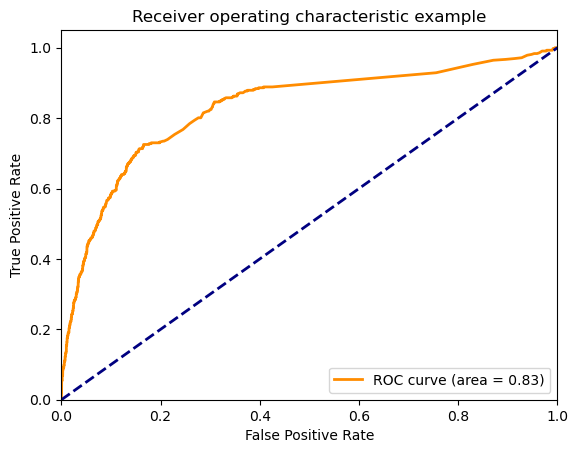

array([1.97349864, 0.97349864, 0.94903629, 0.91026352, 0.87941821,
       0.87915007, 0.86315371, 0.84662216, 0.77780405, 0.75332649,
       0.75262742, 0.73756304, 0.72656042, 0.71809546, 0.67929742,
       0.6706014 , 0.66742583, 0.6669385 , 0.65640002, 0.64495664,
       0.64463784, 0.63200787, 0.63071764, 0.60722623, 0.60333517,
       0.60013046, 0.59731625, 0.59447397, 0.59381997, 0.59103233,
       0.5889373 , 0.58836893, 0.57735385, 0.56790694, 0.56362205,
       0.56229662, 0.55722385, 0.55356425, 0.55219819, 0.55192032,
       0.54774559, 0.53870498, 0.53745259, 0.53588039, 0.53517445,
       0.53405539, 0.53260924, 0.53134638, 0.51654917, 0.50276946,
       0.49661693, 0.49619999, 0.49347206, 0.48556305, 0.48515426,
       0.48429095, 0.47743901, 0.47643573, 0.47469081, 0.47168999,
       0.46987778, 0.46599147, 0.465869  , 0.46196985, 0.45805798,
       0.44634382, 0.44612976, 0.44517393, 0.44394343, 0.44353277,
       0.4387485 , 0.43474659, 0.43311438, 0.43122988, 0.43092

In [605]:
fpr, tpr, thresholds = roc_curve(y_test, best_predicted_prob[:,1])
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
thresholds

In [631]:
result = np.where(best_predicted_prob[:, 1] > 0.084682, 1, 0)

In [632]:
precision_score(y_test, result)

0.2504105090311987

In [633]:
recall_score(y_test, result)

0.7227488151658767

In [634]:
f1_score(y_test, result)

0.3719512195121952

In [635]:
cross_val_score(best_clf_lr, x_test, y_test, cv=5).mean()

0.9292451331625721

In [611]:
#To sum up, Linear regression performance on this data can be described by following metrics:
#precision_score = 0.250
#recall_score = 0.723
#f1_score = 0.372
#cross_val_score = 0.930

In [612]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()

parametrs = {'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,30)}

grid_search_clf = GridSearchCV(clf_tree, parametrs, cv=5)
grid_search_clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [613]:
grid_search_clf.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [614]:
best_clf_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
best_clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

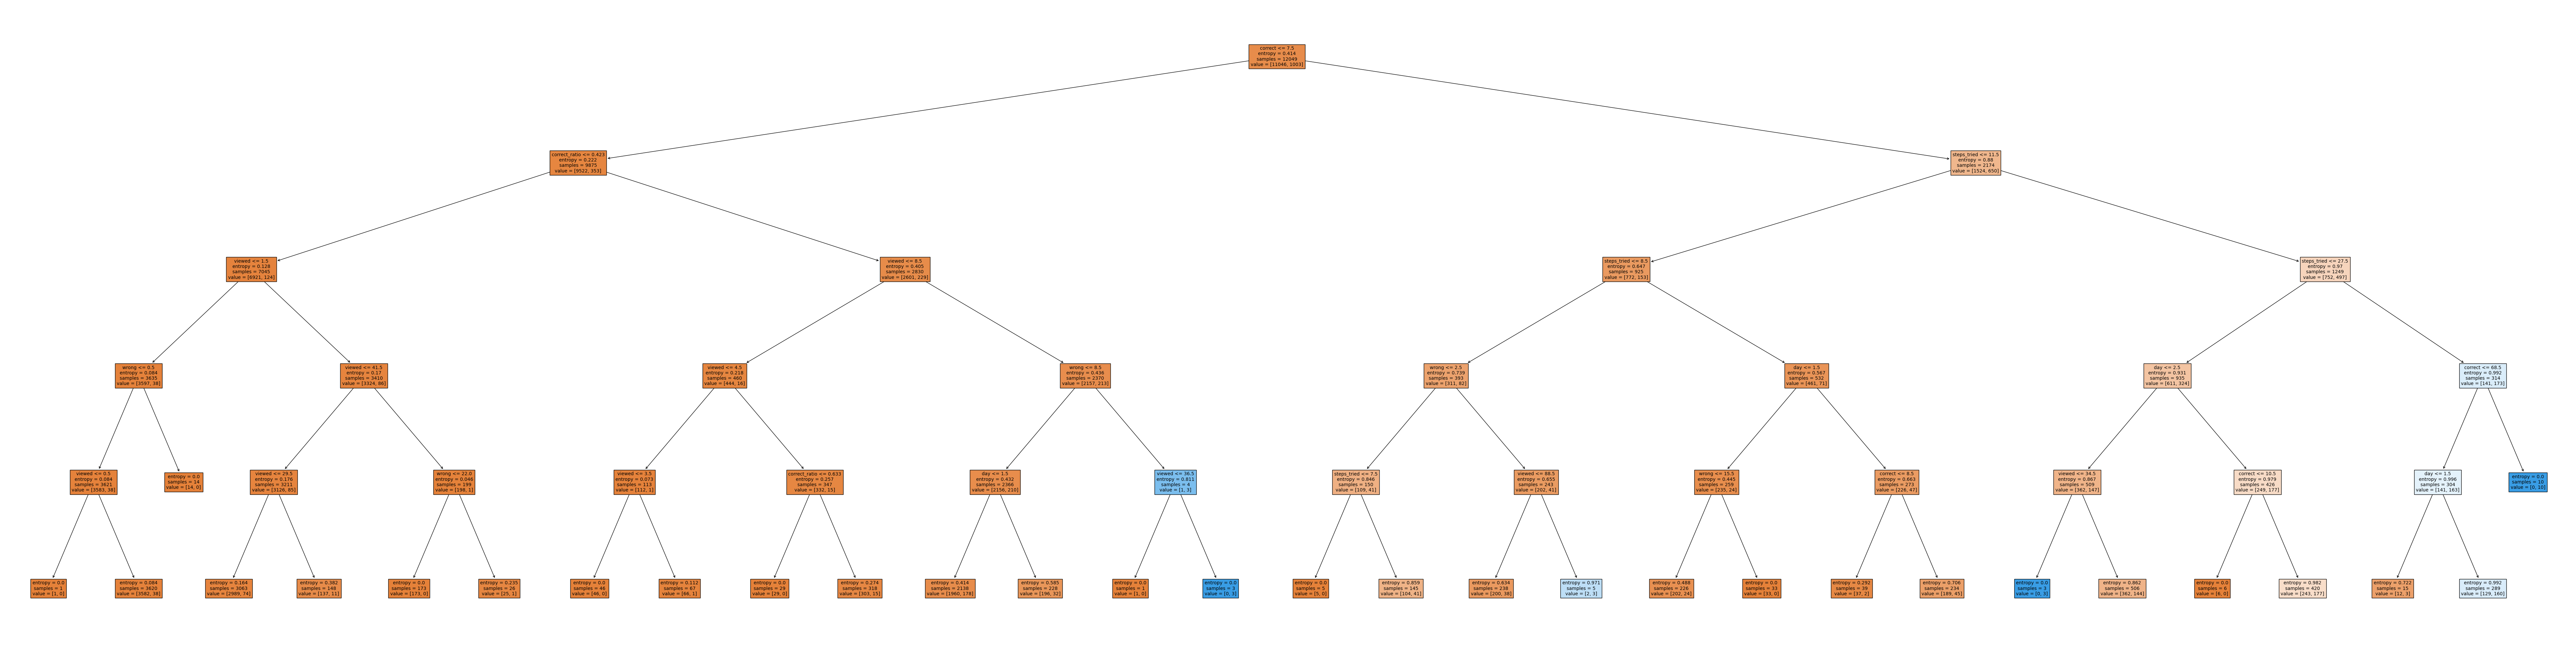

In [615]:
plt.figure(figsize=(100, 25))
tree.plot_tree(best_clf_tree, fontsize=10, feature_names=list(x_train), filled=True);

In [616]:
y_pred_tree = best_clf_tree.predict(x_test)

In [617]:
best_clf_tree.score(x_test, y_test)

0.9272237196765498

In [618]:
precision_score(y_test, y_pred_tree)

0.4642857142857143

In [619]:
recall_score(y_test, y_pred_tree)

0.15402843601895735

In [620]:
cross_val_score(best_clf_lr, x_test, y_test, cv=5).mean()

0.9292451331625721

In [621]:
predicted_prob_tree = best_clf_tree.predict_proba(x_test)

Best Threshold=0.106195, G-Mean=0.778


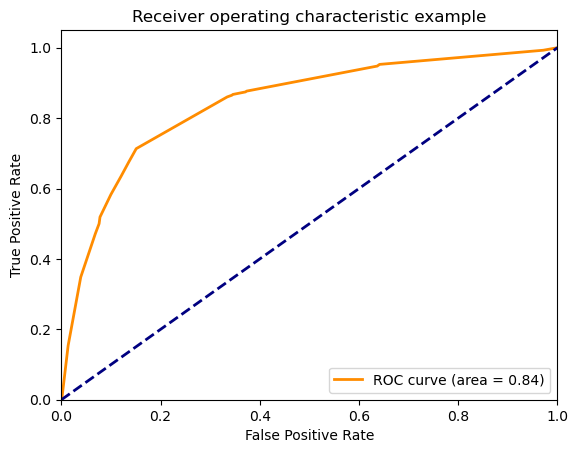

array([2.        , 1.        , 0.6       , 0.55363322, 0.42142857,
       0.28458498, 0.28275862, 0.2       , 0.19230769, 0.15966387,
       0.14035088, 0.10619469, 0.08325538, 0.07432432, 0.05128205,
       0.04716981, 0.03846154, 0.02415932, 0.01492537, 0.01049724,
       0.        ])

In [622]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob_tree[:,1])
roc_auc = auc(fpr, tpr)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
thresholds

array([0.        , 0.01049724, 0.01492537, 0.02415932, 0.03846154,
       0.04716981, 0.05128205, 0.07432432, 0.08325538, 0.10619469,
       0.14035088, 0.15966387, 0.19230769, 0.2       , 0.28275862,
       0.28458498, 0.42142857, 0.55363322, 0.6       , 1.        ])

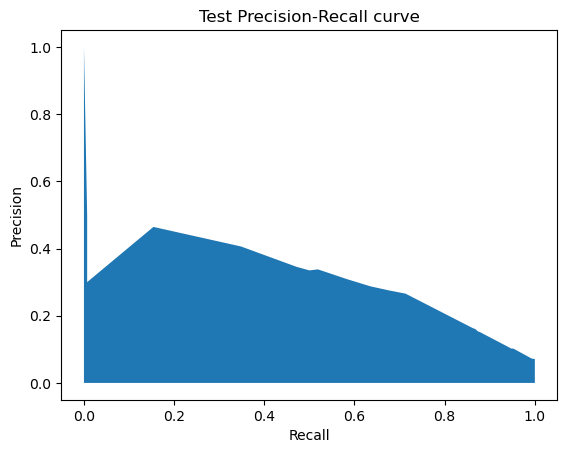

In [623]:
precision, recall, thresholds = precision_recall_curve(y_test, predicted_prob_tree[:,1])
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve");
thresholds

In [641]:
result_tree = np.where(predicted_prob_tree[:, 1] > 0.106195, 1, 0)

In [642]:
precision_score(y_test, result_tree)

0.27562862669245647

In [643]:
recall_score(y_test, result_tree)

0.6753554502369669

In [644]:
f1_score(y_test, result_tree)

0.3914835164835165

In [645]:
cross_val_score(best_clf_tree, x_test, y_test, cv=5).mean()

0.9295822589841123

In [629]:
#To sum up, DecisionTree performance on this data can be described by following metrics (if we are using the best roc-curve threshold)
#precision_score = 0.276
#recall_score = 0.675
#f1_score = 0.391
#cross_val_score = 0.930

In [646]:
result_tree = np.where(predicted_prob_tree[:, 1] > 0.10619469, 1, 0)

In [647]:
precision_score(y_test, result_tree)

0.265666372462489

In [648]:
recall_score(y_test, result_tree)

0.7132701421800948

In [649]:
f1_score(y_test, result_tree)

0.38713826366559484

In [630]:
#To sum up, DecisionTree performance on this data can be described by following metrics (if we are using the PR-curve)
#precision_score = 0.266
#recall_score = 0.713
#f1_score = 0.387
#cross_val_score = 0.930

As we are using a model to predict if the person would complete the course, in my opinion it is better to use a model with the higher recall score - we should try to cover all users who are not going to make it till the end. But our data is an imbalanced classfication (more users tend to fail the course), so we should also loof at f1-scores. Decision tree with a threshold equal to 
0.10619469 is a better option in my opinion.